Using Spark SQL and Spark ML for simple data analytics
--------------------------------------------------------


This notebook show a few sample ways Spark SQL and Spark ML can be used to analyse data.
We will be using the wine quality dataset from: https://archive.ics.uci.edu/ml/datasets/Wine+Quality, which captures various physical properties of wines (alcohol content, acidity etc) and their quality as apprised by wine experts.

Let's start by creating an sqlContext and loading the data from the csv file to a `df` data frame.

In [2]:
#load contents of winequality-white.csv to spark dataframe
df = spark.read.format('csv').options(header='true', inferschema='true', delimiter=';')\
    .load('../data/winequality-red.csv')

Spark (SQL) dataframes represent data of tabular structure (with rows and columns) and are somewhat similar to SQL tables, R or panads dataframes.

Dataframes themselves do not actually store data - they are more recepies on how to apply series of transformations to datasets. To obtain actual data need to extract them from a dataframe into a python object in local memory.

We can for example use `take` to retrieve first n rows of the data as a `list` of `Row` objects.

In [3]:
for r in df.take(3):
    print r

Row(fixed acidity=7.4, volatile acidity=0.7, citric acid=0.0, residual sugar=1.9, chlorides=0.076, free sulfur dioxide=11.0, total sulfur dioxide=34.0, density=0.9978, pH=3.51, sulphates=0.56, alcohol=9.4, quality=5)
Row(fixed acidity=7.8, volatile acidity=0.88, citric acid=0.0, residual sugar=2.6, chlorides=0.098, free sulfur dioxide=25.0, total sulfur dioxide=67.0, density=0.9968, pH=3.2, sulphates=0.68, alcohol=9.8, quality=5)
Row(fixed acidity=7.8, volatile acidity=0.76, citric acid=0.04, residual sugar=2.3, chlorides=0.092, free sulfur dioxide=15.0, total sulfur dioxide=54.0, density=0.997, pH=3.26, sulphates=0.65, alcohol=9.8, quality=5)


We can  also easily convert a spark dataframe to pandas to display it. 

Be aware however that spark dataframes can contain billions of rows, and it may not be practical to convert them in their entirety (you will run out of RAM). We can subset the spark datafame first using for example `limit` to take only n first elements.

In [5]:
#take 3 first rows and convert is to pandas
df.limit(3).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


Every dataframe has an associated schema, which describes its colums, their types and other properties.

In [4]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In our case the schema was inferred from the data in the 'winequality-white.csv' file, and spark is usually able to infer or retrieve the schema from variety of sources (e.g. JSON or parquet files). But it is also possible to define the schema expclicitely.

We can check how may rows a dataframe has with `count`

In [6]:
df.count()

1599

Our dataframe is very small. In fact it is so small that we could easily analyse using standard python tools. However the code below,  which is currenlty running on a sigle computer can be easily run on large spark clusters to analyse dataframes with billions of rows.

### Analysing data with (Spark) SQL

With Spark SQL we can treat dataframes as relational tabeles and query them using SQL like language (stricly speaking its HQL - Hive Query Language)

For example we can register our dataframe as temporary table named `wine` and then use SQL to calculate the average alcohol content per wine quality.

In [7]:
df.registerTempTable('wine')
sqlContext.sql("SELECT quality, avg(alcohol) AS avg_alcohol FROM wine GROUP BY quality").toPandas()

,quality,avg_alcohol
0,6,10.629519
1,3,9.955000
2,5,9.899706
3,4,10.265094
4,8,12.094444
5,7,11.465913


### Machine Learning with Spark ML

Here we will show a few example of using Spark ML to build regression models, predicting the quality of wine based it its properties.

First we need to preprocess our data a bit. Spark ML works primarily on `double` values and our `quality` is currently of type `int`. We can use the following SQL statement to convert it to `double` in column `label`:

In [8]:
data = sqlContext.sql("SELECT *, CAST(quality AS DOUBLE) AS label FROM wine")
data.cache()

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int, label: double]

We have called the new dataframe `data` and applied caching to it. This will tell Spark to try to cache the data in memory for faster access.

We will now try to build a simple lineary regression model that predicts wine quality `label` based on its properties. Spark requires that all the predictors (features) are combined into a single feature vector. We can use VectorAssemble to build it from selected columns of our dataframe (we will use all properties):

In [9]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

input_colums=map(lambda s:s.name,df.schema.fields)[:-1]
print "Selected columns: %s" % input_colums
assembler = VectorAssembler(inputCols=input_colums, outputCol="features")
output = assembler.transform(data)
print(output.select("features", "label").first())

Selected columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Row(features=DenseVector([7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]), label=5.0)


We can use the assembler to `transform` our input dataframe into one that includes the feature vector (`features`) and the response (`label`) as show above.

Now we are ready to build a simple regession model. We will first split our data into traning and testing set and then train a regression model on the former one. Rather then using our transformed `output` we will chaing the preprocessing (vector assemblling) and model traning into a simple `pipeline` that will alow us to use our original data. In general pipelines may include may steps dealing with feature preprocessing, extraction etc.

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

(trainingData, testData) = data.randomSplit([0.7, 0.3])

lr = LinearRegression(maxIter=30, regParam=0.3, elasticNetParam=0.3, featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[assembler, lr])
# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

We can now retrieve the linear regression model from the pipeline (stage 1) and look at the coefficients:  

In [11]:
lrModel = model.stages[1]
# summary only
for t in zip(input_colums, lrModel.coefficients):
    print t

('fixed acidity', 0.0)
('volatile acidity', -0.811768772631562)
('citric acid', 0.0)
('residual sugar', 0.0)
('chlorides', 0.0)
('free sulfur dioxide', 0.0)
('total sulfur dioxide', -0.00020297790567970183)
('density', 0.0)
('pH', 0.0)
('sulphates', 0.25459296225894684)
('alcohol', 0.19996733044423184)


You may notice that for most properties the coefficients are zero, which means that they do not contribute (accoriding to this specific model) to wine quality. This model is using elastic net regularisation which naturally 'selects' the most importnat variables.

Now we can use the testing set to evaluate the peformance of our model with Root Mean Squared Error:

In [12]:
# Make predictions.
predictions = model.transform(testData)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.669663


To get some insights into how good the model is we can try to compare it to the 'zero' model that predicts the mean of `quality`.

In [13]:
mean_quality = trainingData.groupBy().avg('label').first()[0]
zero_prediction = testData.selectExpr('label',"CAST(%s AS DOUBLE) AS prediction" % mean_quality)
zero_rmse = evaluator.evaluate(zero_prediction)
print("RMSE of 'zero model' on test data = %g" % zero_rmse)
R2= (zero_rmse**2-rmse**2)/zero_rmse**2
print "R2 = %g"% R2

RMSE of 'zero model' on test data = 0.78785
R2 = 0.277521


It appears that our model explains about 20% of variablity in data, which is rather a weak result.

Perhaps we can get better results if we can tune the parameters of the model. 

Spark ML comes with a ready to use parameter optimiser that uses cross validation from select the set of parameter from given search grid.

In [14]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

search_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.3, 0.6]) \
    .addGrid(lr.elasticNetParam, [0.4, 0.6, 0.8]).build()
    
cv = CrossValidator(estimator = pipeline, estimatorParamMaps = search_grid, evaluator = evaluator, numFolds = 3)
cv_model = cv.fit(trainingData)

In [15]:
cv_predictions = cv_model.transform(testData)
cv_rmse = evaluator.evaluate(cv_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % cv_rmse)
cv_R2= (zero_rmse**2-cv_rmse**2)/zero_rmse**2
print "R2 = %g"% cv_R2

Root Mean Squared Error (RMSE) on test data = 0.642097
R2 = 0.335775


This model is slightly better explaining 27% of variance but still not very good.

We can now use matplot lib to for example visualise residuals vs predicted values.

In [16]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


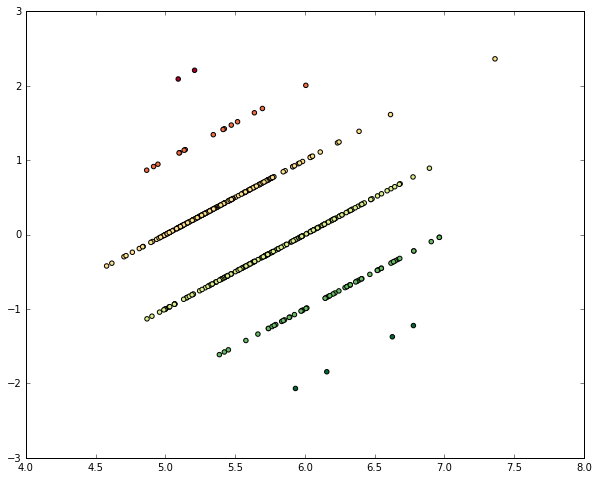

In [17]:
true_values = np.array([r.label for r in cv_predictions.select('label').collect()])
predicted_values = np.array([r.prediction for r in cv_predictions.select('prediction').collect()])
residuals = predicted_values - true_values

import matplotlib.pyplot as plt
plt.scatter(predicted_values, residuals, c=true_values, cmap=plt.get_cmap('RdYlGn'))

It appears that overall this model tends to overstimate quality of bad wines and underestimate quality of good ones.

But perhaps we can do better with a more complex model? Let's try to use RandomForest.

In [18]:
from pyspark.ml.regression import RandomForestRegressor


rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxBins=128, maxDepth=20, \
                           minInstancesPerNode=5, seed=33)
rf_pipeline = Pipeline(stages=[assembler, rf])

# Train model.  This also runs the indexer.
rf_model = rf_pipeline.fit(trainingData)
# Make predictions.
rf_predictions = rf_model.transform(testData)

In [19]:
rf_rmse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rf_rmse)
rf_R2= (zero_rmse**2-rf_rmse**2)/zero_rmse**2
print "R2 = %g"% rf_R2

Root Mean Squared Error (RMSE) on test data = 0.587682
R2 = 0.443586


Random forest gives a much better model that explains 42% of variance. This is an improvement over the linear models but overall the perfomance is rather week.

### Data visualisation

Here we will use Principal Component Analysis to reduce the data dimesionalit so that we can plot the in 2D space.

As before we will create a multi step pipeline that will:

* assemble the feature vector from all predictors
* normalise the features (to 0 mean and 1 stddev) 
* extract two most significant PCA components


In [20]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

input_cols = map(lambda s:s.name,df.schema.fields)[0:-1]
print "Input features: %s" % input_cols


all_assembler = VectorAssembler(
    inputCols=input_cols,
    outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="norm_features")
pca = PCA(k=2, inputCol="norm_features", outputCol="pca_features")

pca_pipeline = Pipeline(stages=[all_assembler, normalizer, pca])

pca_model = pca_pipeline.fit(data)

pca_model.transform(data).first()

Input features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


Row(fixed acidity=7.4, volatile acidity=0.7, citric acid=0.0, residual sugar=1.9, chlorides=0.076, free sulfur dioxide=11.0, total sulfur dioxide=34.0, density=0.9978, pH=3.51, sulphates=0.56, alcohol=9.4, quality=5, label=5.0, features=DenseVector([7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]), norm_features=DenseVector([0.1952, 0.0185, 0.0, 0.0501, 0.002, 0.2901, 0.8966, 0.0263, 0.0926, 0.0148, 0.2479]), pca_features=DenseVector([0.1543, -0.0236]))

The `pca_features` column now contains the reduced 2D representation of all other features.

We can now use it to visualise a 30% sample of the data. The color represents quality of wine.


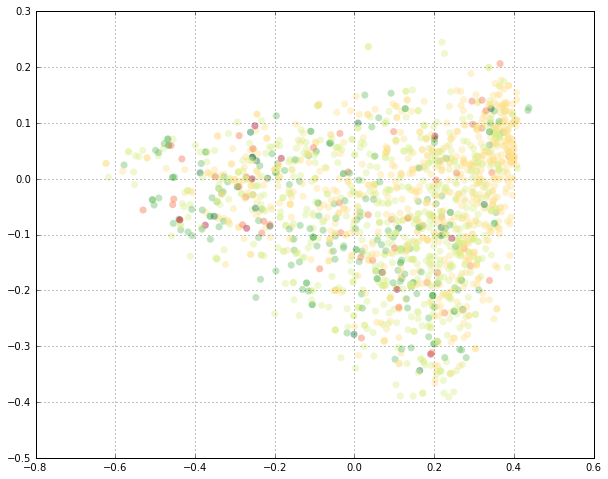

In [22]:
import matplotlib.pyplot as plt
pca_data = pca_model.transform(data)

sampling_fraction = 1.0

pca_xy = np.matrix(map(lambda r:r.pca_features.array, pca_data.sample(False, sampling_fraction, 13).collect()))
pca_colors = map(lambda r: float(r.quality),data.select('quality').sample(False, sampling_fraction, 13).collect())

plt.scatter(pca_xy[:,0], pca_xy[:,1], c=pca_colors, alpha=0.4, cmap=plt.get_cmap('RdYlGn'), edgecolors='none', s=50)
plt.grid(True)
plt.show()

Unfortunatelly Spark ML currently does not provide information on how much variance is explained by the two component or what they are.
Still there are some obvious areas dominated by good and bad quality wines.